# 4. Maximum Likelihood Fitting

**Pedagogical context.** This notebook covers Cowan's Lectures 9 through
11 (parameter estimation and maximum likelihood) and Prosper's Lectures
4 through 5 (frequentist inference: estimation). It also draws on
Cranmer's "Estimators" chapter in *Statistics and Data Science*.

Maximum likelihood estimation (MLE) finds the parameter values that
maximise the likelihood function, or equivalently minimise the negative
log-likelihood. In particle physics, the minimisation is performed by
MINUIT (or its Python descendant iminuit), which uses a combination of
gradient descent and simplex methods. Histimator wraps iminuit behind a
`fit` function that handles all the bookkeeping: it constructs the
BinnedNLL, sets up parameter bounds and starting values, runs MIGRAD
and HESSE, and returns a structured FitResult.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Histogram, Sample, Channel, Model
from histimator.likelihood import BinnedNLL, fit

## 4.1 The BinnedNLL class

BinnedNLL is a callable that computes the negative log-likelihood for
a given set of parameter values. It builds the Poisson log-probability
for each bin, adds Gaussian constraint terms for nuisance parameters,
and returns a single scalar. This is the function that iminuit
minimises.

The NLL has two components. The main term is the sum of Poisson
log-probabilities across all bins and channels. The constraint terms
add penalty terms that encode prior knowledge about nuisance parameters:
NormSys and HistoSys alphas are constrained by standard Gaussians
$\mathcal{N}(0, 1)$, StatError gammas by $\mathcal{N}(1, \delta_i)$,
and ShapeSys gammas by Poisson auxiliary measurements.

In [2]:
# Build a test model
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

signal = Sample("signal", Histogram([3, 10, 15, 10, 3], edges))
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

background = Sample("background", Histogram([50, 60, 55, 45, 40], edges))
background.add_normsys("bkg_norm", lo=0.9, hi=1.1)

np.random.seed(42)
true_mu = 1.5
true_expected = true_mu * signal.histogram.values + background.histogram.values
data = np.random.poisson(true_expected.astype(int))

ch = Channel("SR")
ch.add_sample(signal)
ch.add_sample(background)
ch.set_data(data)

model = Model("fitting_demo")
model.add_channel(ch)

# Create and evaluate the NLL
nll = BinnedNLL(model)
nominal_nll = nll([1.0, 0.0])  # mu=1, alpha=0
print(f"NLL at nominal: {nominal_nll:.3f}")

# Evaluate at a few points
for mu_val in [0.0, 0.5, 1.0, 1.5, 2.0]:
    val = nll([mu_val, 0.0])
    print(f"  NLL(mu={mu_val:.1f}, alpha=0) = {val:.3f}")

NLL at nominal: 21.483
  NLL(mu=0.0, alpha=0) = 34.609
  NLL(mu=0.5, alpha=0) = 26.055
  NLL(mu=1.0, alpha=0) = 21.483
  NLL(mu=1.5, alpha=0) = 20.268
  NLL(mu=2.0, alpha=0) = 21.928


## 4.2 Fitting with iminuit

The `fit` function wraps the full MIGRAD + HESSE procedure. MIGRAD
finds the minimum; HESSE computes the covariance matrix at the
minimum by inverting the matrix of second derivatives. The FitResult
contains the best-fit values, parabolic (Hesse) errors, the full
covariance matrix, and the underlying Minuit object for advanced
inspection.

In [3]:
result = fit(model)

print(f"Converged: {result.valid}")
print(f"Minimum NLL: {result.nll_min:.3f}")
print()
for name in model.parameter_names:
    bf = result.bestfit[name]
    err = result.errors[name]
    print(f"  {name:>12s} = {bf:+.4f} +/- {err:.4f}")

print(f"\nCorrelation(mu, bkg_norm): "
      f"{result.covariance[('mu', 'bkg_norm')] / (result.errors['mu'] * result.errors['bkg_norm']):.3f}")

Converged: True
Minimum NLL: 20.166

            mu = +1.2585 +/- 0.7675
      bkg_norm = +0.3526 +/- 1.1811

Correlation(mu, bkg_norm): -0.861


The negative correlation between `mu` and `bkg_norm` makes physical
sense: if the background normalisation increases, less signal is needed
to explain the data, so $\hat{\mu}$ decreases. This is the same
correlation we saw in the 2D contour plot in Notebook 01.

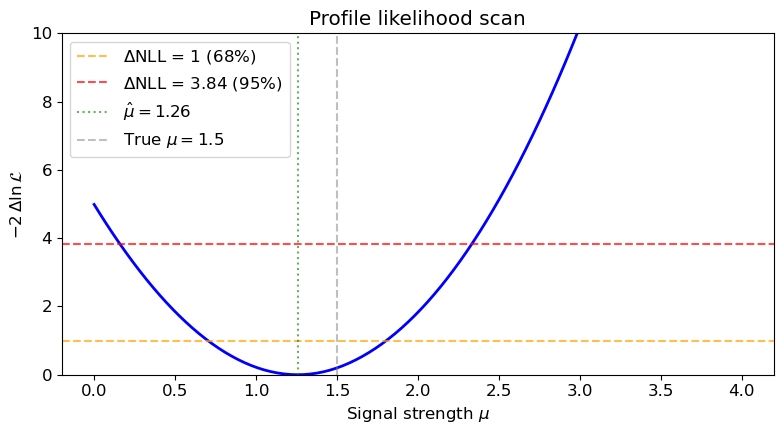

In [4]:
# Visualise: NLL profile as a function of mu
mu_scan = np.linspace(0, 4, 100)
nll_profile = []
for mu_val in mu_scan:
    # Profile over bkg_norm at each mu
    from iminuit import Minuit
    nll_obj = BinnedNLL(model)
    m = Minuit(nll_obj, [mu_val, 0.0], name=model.parameter_names)
    m.errordef = 1
    for p in model.parameters:
        if p.bounds:
            m.limits[p.name] = p.bounds
    m.values["mu"] = mu_val
    m.fixed["mu"] = True
    m.migrad()
    nll_profile.append(float(m.fval))

delta_nll = 2 * (np.array(nll_profile) - result.nll_min)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(mu_scan, delta_nll, "b-", linewidth=2)
ax.axhline(1.0, color="orange", ls="--", alpha=0.7, label=r"$\Delta$NLL = 1 (68%)")
ax.axhline(3.84, color="red", ls="--", alpha=0.7, label=r"$\Delta$NLL = 3.84 (95%)")
ax.axvline(result.bestfit["mu"], color="green", ls=":", alpha=0.6,
           label=rf"$\hat{{\mu}} = {result.bestfit['mu']:.2f}$")
ax.axvline(true_mu, color="gray", ls="--", alpha=0.5,
           label=rf"True $\mu = {true_mu}$")
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$-2\,\Delta\ln\mathcal{L}$")
ax.set_title("Profile likelihood scan")
ax.set_ylim(0, 10)
ax.legend()
plt.tight_layout()
plt.show()

## 4.3 MINOS errors

The Hesse errors assume the likelihood is parabolic, which is exact for
a Gaussian model and approximate otherwise. MINOS computes asymmetric
errors by finding the parameter values where $\Delta$NLL = 0.5 on each
side of the minimum. For well-behaved likelihoods the two methods agree;
for skewed likelihoods (low statistics, parameters near boundaries)
MINOS gives more accurate intervals.

In [5]:
result_minos = fit(model, run_minos=True)

print("MINOS errors:")
for name, (lo, hi) in result_minos.minos_errors.items():
    hesse = result_minos.errors[name]
    print(f"  {name:>12s}: Hesse = +/- {hesse:.4f}, "
          f"MINOS = [{lo:+.4f}, {hi:+.4f}]")

MINOS errors:
            mu: Hesse = +/- 0.7675, MINOS = [-0.7894, +0.7762]
      bkg_norm: Hesse = +/- 1.1811, MINOS = [-1.1647, +1.1783]


## 4.4 Post-fit model vs data

After fitting, the expected yields computed at the best-fit parameter
values should match the observed data within statistical fluctuations.
Plotting the post-fit prediction against data, with a ratio panel below,
is the standard way to assess fit quality. Systematic pulls (deviations
of nuisance parameters from nominal) indicate which uncertainties the
fit is using to absorb data-model discrepancies.

/var/folders/3w/jcz46dj964526sk_kgkg8p0r0000gn/T/ipykernel_12198/464983816.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


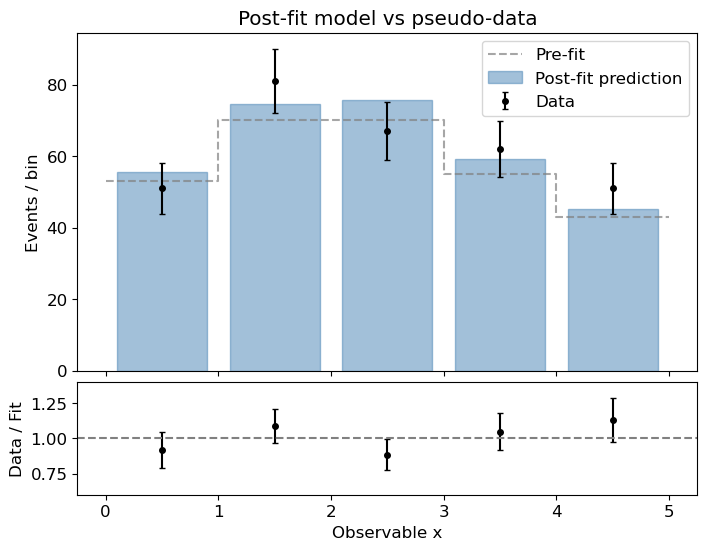

In [6]:
postfit = model.channels[0].expected(result.bestfit)
prefit = model.channels[0].expected(model.nominal_values())
centres = signal.histogram.centres

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[3, 1],
                                sharex=True, gridspec_kw={"hspace": 0.05})

ax1.bar(centres, postfit, width=0.8, alpha=0.5, color="steelblue",
        edgecolor="steelblue", label="Post-fit prediction")
ax1.step(np.append(edges[:-1], edges[-1]),
         np.append(prefit, prefit[-1]),
         where="post", color="gray", ls="--", alpha=0.7, label="Pre-fit")
ax1.errorbar(centres, data, yerr=np.sqrt(data),
             fmt="ko", ms=4, capsize=2, label="Data")
ax1.set_ylabel("Events / bin")
ax1.legend()
ax1.set_title("Post-fit model vs pseudo-data")

ratio = data / postfit
ax2.errorbar(centres, ratio, yerr=np.sqrt(data) / postfit,
             fmt="ko", ms=4, capsize=2)
ax2.axhline(1, color="gray", ls="--")
ax2.set_ylabel("Data / Fit")
ax2.set_xlabel("Observable x")
ax2.set_ylim(0.6, 1.4)
plt.tight_layout()
plt.show()

## 4.5 Multiple starting points and fit stability

Minimisation can find local minima rather than the global minimum,
especially in models with many parameters. A standard robustness check
is to refit from several different starting points and verify that the
same minimum is reached each time.

In [7]:
# Refit from different starting values
results = []
for mu_start in [0.1, 1.0, 3.0, 5.0]:
    r = fit(model, mu=mu_start)
    results.append((mu_start, r.bestfit["mu"], r.nll_min, r.valid))
    print(f"  Start mu={mu_start:.1f}: fitted mu={r.bestfit['mu']:.4f}, "
          f"NLL={r.nll_min:.3f}, valid={r.valid}")

# Check all converge to same minimum
nll_vals = [r[2] for r in results]
print(f"\nNLL spread: {max(nll_vals) - min(nll_vals):.6f} (should be ~0)")

  Start mu=0.1: fitted mu=1.2586, NLL=20.166, valid=True
  Start mu=1.0: fitted mu=1.2585, NLL=20.166, valid=True
  Start mu=3.0: fitted mu=1.2583, NLL=20.166, valid=True
  Start mu=5.0: fitted mu=1.2573, NLL=20.166, valid=True

NLL spread: 0.000010 (should be ~0)


## Exercises

**Exercise 4.1.** Build a model with a background that has three
NormSys modifiers (representing three independent systematic sources).
Fit the model and examine the covariance matrix. Are the nuisance
parameters correlated with each other, or only with $\mu$?

**Exercise 4.2.** Generate pseudo-data from a model with $\mu = 0$
(background-only) and fit with $\mu$ free. Report the fitted
$\hat{\mu}$ and its error. Repeat 100 times with different random
seeds and plot the distribution of $\hat{\mu}$. Verify that it is
approximately Gaussian with mean near 0 and standard deviation matching
the Hesse error.

**Exercise 4.3.** Compare Hesse and MINOS errors in a low-statistics
regime. Reduce all background yields by a factor of 10 (so you have
order-1 events per bin) and repeat the fit. Explain why MINOS gives
asymmetric errors while Hesse does not.

## References

G. Cowan, *Statistical Data Analysis*, Lectures 9 through 11.

H. Prosper, "Statistics in Particle Physics", LPC/Fermilab 2021.
Lectures 4 and 5.

F. James, *Statistical Methods in Experimental Physics*, 2nd edition.
World Scientific, 2006. Chapters on MINUIT.

K. Cranmer, "Estimators", in *Statistics and Data Science*, NYU.